In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import math

## Functions

__Function for getting the dynamic parameters of the cell model__

In [2]:
def get_dyn_param(data,cell_temp):    
    
    ind = np.where(np.array(data['temps']) == cell_temp)[0][0]

    eta = data['etaParam'][ind]
    Q = data['QParam'][ind]
    gamma = data['GParam'][ind]
    M0 = data['M0Param'][ind]
    M = data['MParam'][ind]
    R0 = data['R0Param'][ind]
    RC = data['RCParam'][ind]
    RC = np.exp(-np.divide(1,RC))
    R = data['RParam'][ind]

    return (eta,Q,gamma,M0,M,R0,RC,R)

__OCV calculation for any SOC value Function__

In [3]:
from scipy.interpolate import interp1d

def interp_ocv(z,OCV):
    
    dum = interp1d(z,OCV)
    
    return dum

In [4]:
def OCV_from_SOC(z,temp,SOC,OCV_0,OCV_rel):

    # OCV calculation from the given SOC (Coloumb Counting)

    OCV_0_z = interp_ocv(SOC,OCV_0)(z)
    OCV_rel_z = interp_ocv(SOC,OCV_rel)(z)

    ocv_z = OCV_0_z + temp*OCV_rel_z

    return (ocv_z)

## Main Code


__Importing Dynamic Model__

In [5]:
data = pd.read_pickle('E2model.pkl')

__User Inputs__

In [6]:
# Simulation Time
maxtime = 3000

# Cell Temperature
cell_temp = 25

# Initial SOC
z = 0.5

# Diffusion current
irc = 0

# Hysterisis paramter
h = -1

# Constant Current Limit
cc = 9

# Constant Power Limit 
cp = 35

# Maximum allowable cell voltage
maxV = 4.15

In [7]:
# Cell Parameters calculated from dynamic model

eta = get_dyn_param(data,cell_temp)[0] 
Q = get_dyn_param(data,cell_temp)[1] 
gamma = get_dyn_param(data,cell_temp)[2]
M0 = get_dyn_param(data,cell_temp)[3]
M = get_dyn_param(data,cell_temp)[4]
R0 = get_dyn_param(data,cell_temp)[5]
RC = get_dyn_param(data,cell_temp)[6]
R = get_dyn_param(data,cell_temp)[7]

# Static Parameters
SOC = data['SOC']
OCV_0  = data['OCV0']
OCV_rel = data['OCVrel']

__Storage Variables__

In [8]:
z_store = np.zeros((2,maxtime))
v_term = np.zeros((2,maxtime))
i_store = np.zeros((2,maxtime))
Power = np.zeros((2,maxtime))

__CC/CV Charging Strategy__

In [9]:
for i in range(maxtime):
    
    # Terminal Voltage Calculation
    v = OCV_from_SOC(z,cell_temp,SOC,OCV_0,OCV_rel) + M*h - R*irc

    # Charging Current
    ik = (v - maxV)/R0
    ik  = max(-cc,ik)

    # SOC update
    z = z - (1/3600)*ik/Q

    # Diffusion current
    irc = RC*irc + (1-RC)*ik

    # Hysterisis factor calculation
    fac = np.exp(-np.abs(gamma*ik)/(3600*Q))

    # Hysterisis calculation
    h = fac*h + (fac-1)*np.sign(ik)

    # Storing the variables

    z_store[0][i] = z
    v_term[0][i] = v-ik*R0
    i_store[0][i] = ik
    Power[0][i] = ik*v_term[0][i]

__CP/CV Charging Strategy__

In [10]:
# Initial SOC
z = 0.5

# Diffusion current
irc = 0

# Hysterisis paramter
h = -1

In [11]:
for i in range(maxtime):
    
    # Terminal Voltage Calculation
    v = OCV_from_SOC(z,cell_temp,SOC,OCV_0,OCV_rel) + M*h - R*irc
    
    # Constant Power charging
    ik = (v - np.sqrt(v**2 - 4*R0*(-cp)))/(2*R0)
    
    # If voltage exceeds the limit do CV strategy
    
    if ((v - ik*R0) > maxV):
        
        # Charging Current
        ik = (v - maxV)/R0
        
    # SOC update
    z = z - (1/3600)*ik/Q

    # Diffusion current
    irc = RC*irc + (1-RC)*ik

    # Hysterisis factor calculation
    fac = np.exp(-np.abs(gamma*ik)/(3600*Q))

    # Hysterisis calculation
    h = fac*h + (fac-1)*np.sign(ik)

    # Storing the variables

    z_store[1][i] = z
    v_term[1][i] = v-ik*R0
    i_store[1][i] = ik
    Power[1][i] = ik*v_term[0][i]

<Figure size 432x288 with 0 Axes>

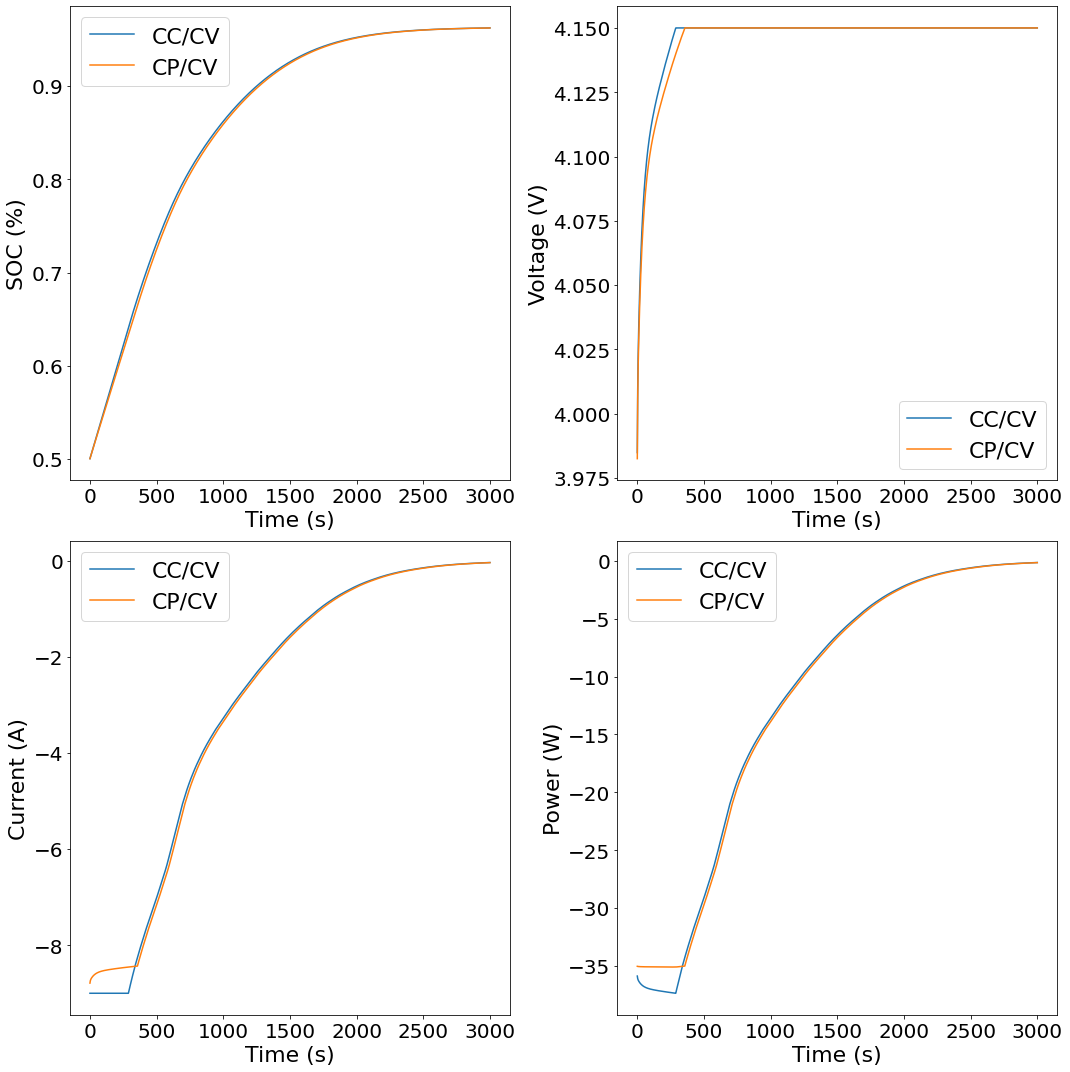

In [12]:
plt.clf()

fig, ax = plt.subplots(2, 2, figsize=(15,15))


ax[0, 0].plot(z_store[0])
ax[0, 0].plot(z_store[1])
ax[0, 0].set_xlabel('Time (s)',size = 22)
ax[0, 0].set_ylabel('SOC (%)',size = 22)
ax[0, 0].legend(['CC/CV','CP/CV'], prop={'size': 22})
ax[0,0].tick_params(axis='both', which='major', labelsize=20)

ax[0, 1].plot(v_term[0])
ax[0, 1].plot(v_term[1])
ax[0, 1].set_xlabel('Time (s)',size = 22)
ax[0, 1].set_ylabel('Voltage (V)',size = 22)
ax[0, 1].legend(['CC/CV','CP/CV'], prop={'size': 22})
ax[0,1].tick_params(axis='both', which='major', labelsize=20)

ax[1, 0].plot(i_store[0])
ax[1, 0].plot(i_store[1])
ax[1, 0].set_xlabel('Time (s)',size = 22)
ax[1, 0].set_ylabel('Current (A)',size = 22)
ax[1, 0].legend(['CC/CV','CP/CV'], prop={'size': 22})
ax[1,0].tick_params(axis='both', which='major', labelsize=20)

ax[1, 1].plot(Power[0])
ax[1, 1].plot(Power[1])
ax[1, 1].set_xlabel('Time (s)',size = 22)
ax[1, 1].set_ylabel('Power (W)',size = 22)
ax[1, 1].legend(['CC/CV','CP/CV'], prop={'size': 22})
ax[1,1].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

plt.show()
